# Conv1D - UNet

In [1]:
skip_training = False  # Set this flag to True before validation and submission

In [2]:
# During evaluation, this cell sets skip_training to True

import tools, warnings
warnings.showwarning = tools.customwarn

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F

In [69]:
# When running on your own computer, you can specify the data directory by:
# data_dir = tools.select_data_dir('/your/local/data/directory')
data_dir = tools.select_data_dir()

output_dir = tools.select_data_dir('./output/')

The data directory is ../data
The data directory is ./output/


In [61]:
# Select device which you are going to use for training
device = torch.device("cuda:0")
# device = torch.device("cpu")

In [6]:
if skip_training:
    # The models are always evaluated on CPU
    device = torch.device("cpu")

## Data

In [7]:
from data import MotusDataset_best_of, plot_dataset_sample

cutoff = 1 # length of IR
resample_rate = None

trainset = MotusDataset_best_of(root=data_dir, train=True, split=0.05, cutoff=cutoff, resample=resample_rate)
trainloader = torch.utils.data.DataLoader(dataset=trainset)
# trainloader = torch.utils.data.DataLoader(dataset=trainset, batch_size=1, collate_fn=collate, shuffle=True)

# testset = MotusDataset_best_of(root=data_dir, train=False, cutoff=cutoff, num_tail_samples=num_tail_samples, resample=None)
# testloader = torch.utils.data.DataLoader(dataset=testset)

../data\Motus/best_of/sh_rirs
Dataset with 2 samples. 
Input(channels, time_dim), output(...) shapes: torch.Size([1, 2400]), torch.Size([1, 45600])


Let's visualize the data with some plots, and audio play the head and tail

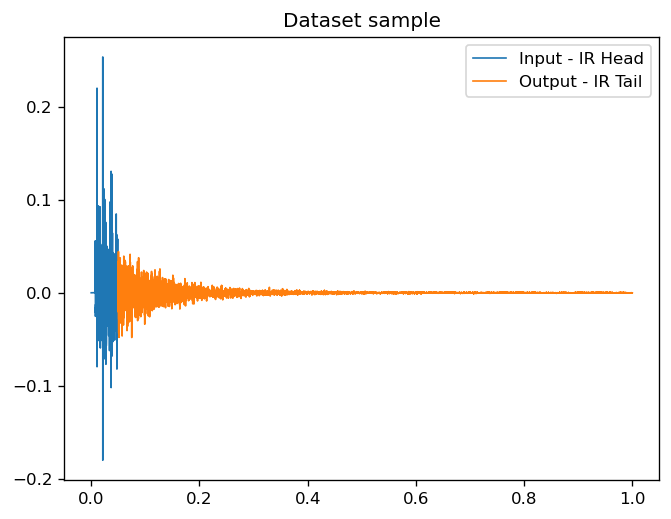

In [8]:
sample_head, sample_tail = plot_dataset_sample(trainset,dpi=120)

In [9]:
from IPython.display import Audio, display

sample_head, sample_tail = trainset[0]
fs = trainset.sample_rate
Audio(torch.cat((sample_head[0], sample_tail[0]), dim=0), rate=fs)

# Architecture

Lightweight model: model ideas from these two papers [Seq-U-Net](https://arxiv.org/pdf/1911.06393.pdf) and [Wave-U-Net](https://arxiv.org/pdf/1806.03185.pdf)

Architecture: 
* Downsampling Block:
    * Conv1D (out_channels=32, kernel_size=16, stride=8) -> skip connection
    * LeakyReLU
    * Dropout (omit?)
    * Conv1D (out_channels=32, kernel_size=3, stride=1)
    * Conv1D (out_channels=32, kernel_size=4, stride=4) + Leaky ReLU
    * Conv1D (out_channels=32, kernel_size=2, stride=2) + Leaky ReLU 
    - Conv1D (out_channels=128, kernel_size=2, stride=2) + Leaky ReLU 
    - Conv1D (out_channels=128, kernel_size=2, stride=2) + Leaky ReLU 
    - Conv1D (out_channels=128, kernel_size=2, stride=2) + Leaky ReLU 
    - Conv1D (out_channels=out_channels, kernel_size=2, stride=2) + Leaky ReLU 
    - linear layer (hidden size, hidden size) + Leaky ReLU 
    - linear layer (hidden size, 1)


In [157]:
# test architecture sizes

m1 = nn.Conv1d(1, 32, 16, stride=4)
m2 = nn.LeakyReLU()
m3 = nn.Dropout()
m4 = nn.Conv1d(32, 32, 3, stride=3)

m5 = nn.Conv1d(32, 64, 4, stride=1)
m6 = nn.LeakyReLU()
m7 = nn.Dropout()
m8 = nn.Conv1d(64, 64, 3, stride=3)

m9 = nn.Conv1d(64, 64, 4, stride=1)
m10 = nn.LeakyReLU()
m11 = nn.Dropout()
m12 = nn.Conv1d(64, 64, 3, stride=3)

m13 = nn.Conv1d(64, 64, 3, stride=1)

input = torch.rand(1, 1, 2400)
out1 = m1(input)
out = m2(out1)
out = m3(out)
print(out.shape)
out = m4(out)
print(out.shape)

out5 = m5(out)
out = m6(out5)
out = m7(out)
print(out.shape)
out = m8(out)
print(out.shape)

out9 = m9(out)
out = m10(out9)
out = m11(out)
print(out.shape)
out = m12(out)
print(out.shape)

# bottleneck
out13 = m13(out)
print(out13.shape)

# transposed convolution
u1 = nn.ConvTranspose1d(64, 64, 3, stride=2, padding=1)
u2 = nn.Conv1d(64, 64, 3)
u3 = nn.ConvTranspose1d(64, 64, 3, stride=2, padding=1)
u4 = nn.Conv1d(64, 32, 3)
u5 = nn.ConvTranspose1d(32, 32, 3, stride=2, padding=1)
u6 = nn.Conv1d(32, 32, 3)




out = u1(out13)
print(out.shape)
out = torch.cat((out, out9),dim=-1)
# out = torch.cat((out, out9[:,:,35:]),dim=-1)
print(out.shape)

out = u2(out)
print(out.shape)

out = u3(out)
print(out.shape)
out = torch.cat((out, out5),dim=-1)
print(out.shape)
out = u4(out)
print(out.shape)

out = u5(out)
print(out.shape)
print(out1.shape)
out = torch.cat((out, out1[:,:,527:]),dim=-1)
print(out.shape)
out = u6(out)
print(out.shape)

u7 = nn.ConvTranspose1d(32, 32, 16, stride=4, padding=1)
# u88 = nn.Conv1d(32, 32, 8, stride=2)
u8 = nn.ConvTranspose1d(32, 16, 8, stride=4, padding=1)
u9 = nn.ConvTranspose1d(16, 16, 8, stride=4, padding=1)
u10 = nn.ConvTranspose1d(16, 16, 4, stride=2, padding=1)
u11 = nn.ConvTranspose1d(16, 1, 4, stride=1, padding=1)

out = u7(out)
# out = u88(out)

out = u8(out)
out = u9(out)
out = u10(out)
out = u11(out)
print(out.shape)



torch.Size([1, 32, 597])
torch.Size([1, 32, 199])
torch.Size([1, 64, 196])
torch.Size([1, 64, 65])
torch.Size([1, 64, 62])
torch.Size([1, 64, 20])
torch.Size([1, 64, 18])
torch.Size([1, 64, 35])
torch.Size([1, 64, 97])
torch.Size([1, 64, 95])
torch.Size([1, 64, 189])
torch.Size([1, 64, 385])
torch.Size([1, 32, 383])
torch.Size([1, 32, 765])
torch.Size([1, 32, 597])
torch.Size([1, 32, 835])
torch.Size([1, 32, 833])
torch.Size([1, 1, 106965])


In [10]:
class Downsample_block(nn.Module):
    def __init__(self, 
                 in_channels, 
                 out_channels, 
                 kernel_size, 
                 stride,
                 dropout=False, 
                 negative_slope=0.01):
        super(Downsample_block, self).__init__()
        
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size[0], stride=stride[0])
        self.nonlin = nn.LeakyReLU(negative_slope)
        if dropout:
            self.drop = nn.Dropout()
        else:
            self.drop = nn.Identity()
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size[1], stride=stride[1])
        
    def forward(self, x):
        skip = self.conv1(x)
        out = self.nonlin(skip)
        out = self.drop(out)
        out = self.conv2(out)
        return out, skip

class Upsample_block(nn.Module):
    def __init__(self, 
                 in_channels, 
                 out_channels, 
                 kernel_size, 
                 convT_stride=2,
                 convT_padding=1,
                 crop_skip=True):
        super(Upsample_block, self).__init__()
        
        self.convT1 = nn.ConvTranspose1d(in_channels, in_channels, kernel_size[0], stride=convT_stride, padding=convT_padding)
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size[0])
        self.crop_skip = crop_skip
        
    def forward(self, x, skip):
        out = self.convT1(x)
        if self.crop_skip:
            out = torch.concat((out, skip[:,:,out.shape[-1]:]),dim=-1)
        else:
            out = torch.concat((out, skip),dim=-1)
        out = self.conv1(out)
        return out

In [50]:
class CNN1D_UNET(nn.Module):
    def __init__(self, in_channels, out_dim, negative_slope=0.01):
        super(CNN1D_UNET,self).__init__()
        self.out_dim=out_dim
        
        self.downsample1 = Downsample_block(in_channels, 
                                            32, 
                                            kernel_size=[16, 3], 
                                            stride=[4, 3], 
                                            negative_slope=negative_slope)
        self.downsample2 = Downsample_block(32, 
                                            128, 
                                            kernel_size=[4, 3], 
                                            stride=[1, 3], 
                                            negative_slope=negative_slope)
        self.downsample3 = Downsample_block(128, 
                                            254, 
                                            kernel_size=[4, 3], 
                                            stride=[1, 3], 
                                            negative_slope=negative_slope)
        self.bottleneckConv = nn.Conv1d(254, 254, 3, stride=1)
        self.upsample1 = Upsample_block(254,
                                        128,
                                        kernel_size=[3, 3],
                                        convT_stride=2,
                                        convT_padding=1,
                                        crop_skip=False)
        self.upsample2 = Upsample_block(128,
                                        32,
                                        kernel_size=[3, 3],
                                        convT_stride=2,
                                        convT_padding=1,
                                        crop_skip=False)
        self.upsample3 = Upsample_block(32,
                                        32,
                                        kernel_size=[3, 3],
                                        convT_stride=2,
                                        convT_padding=1,
                                        crop_skip=True)
        self.convTs = nn.Sequential(nn.ConvTranspose1d(32, 32, 16, stride=4, padding=1),
                                    nn.Conv1d(32, 32, 3),
                                    nn.ConvTranspose1d(32, 32, 8, stride=4, padding=1),
                                    nn.Conv1d(32, 32, 3),
                                    nn.ConvTranspose1d(32, 32, 8, stride=2, padding=1),
                                    nn.Conv1d(32, 32, 3),
                                    nn.ConvTranspose1d(32, 32, 4, stride=2, padding=1),
                                    nn.Conv1d(32, 32, 3),
                                    nn.ConvTranspose1d(32, 32, 4, stride=1, padding=1),
                                    nn.Conv1d(32, 1, 3)
        )
        
    def forward(self, x):
        """
        Args:
            x of shape (batch_size*IR_len, input_mapped_dim = 4*2*10 = 80): 
            Tensor with transformed input position vectors.
        Returns:
            out of shape (batch_size, 1): value for time step t            
        """
        out, skip1 = self.downsample1(x)
#         print(skip1.shape)
        out, skip2 = self.downsample2(out)
        out, skip3 = self.downsample3(out)
#         print(out.shape)
        out = self.bottleneckConv(out)
#         print(out.shape)
        out = self.upsample1(out, skip3)
#         print(out.shape)
        out = self.upsample2(out, skip2)
#         print(out.shape)
        out = self.upsample3(out, skip1)
#         print(out.shape)
        out = self.convTs(out)
#         print(out.shape)
        out = out[:,:,:self.out_dim]
#         print(out.shape)
        return out


In [45]:
def test_CNN1D_UNET_shapes():
    x = torch.randn(2, 1, 2400)
    channels = x.shape[1]
    out_dim = 45600
    model = CNN1D_UNET(channels, out_dim)
    out = model(x)

test_CNN1D_UNET_shapes()

torch.Size([2, 32, 597])
torch.Size([2, 254, 20])
torch.Size([2, 254, 18])
torch.Size([2, 128, 95])
torch.Size([2, 32, 383])
torch.Size([2, 32, 763])
torch.Size([2, 1, 48961])
torch.Size([2, 1, 45600])


Loss: 0.01859140209853649


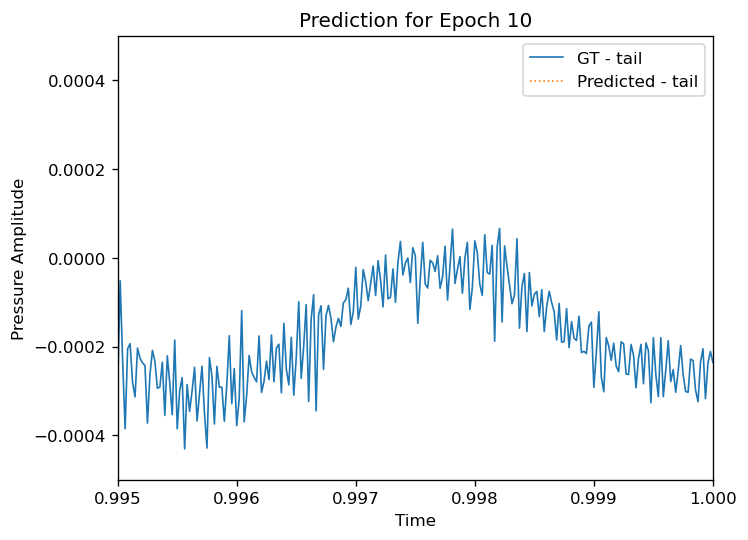

In [56]:
###### Plotting model output every 500 epochs ######
time1 = np.linspace(0,sample_head.shape[-1]/fs, sample_head.shape[-1])
time2 = np.linspace(time1[-1], sample_tail.shape[-1]/fs+time1[-1], sample_tail.shape[-1])
def plot_model_output(model, dataset, epoch, criterion=None, idx=0, plot=True, xlim=None, ylim=None, save_file=False, filename=None):
    with torch.no_grad():
        model.eval()
        x, y = dataset[idx]
        x = x[None,:,:].to(device).float()
        y = y[None,:,:].to(device).float()
        y_pred = model(x)
        if criterion!= None:
            loss = criterion(y_pred,y)
            print(f"Loss: {loss.item()}")
        
        x_ = torch.flatten(x.cpu())
        y_ = torch.flatten(y.cpu())
        y_pred_ = torch.flatten(y_pred.cpu())
        
        #Plot the data 
        if plot:
            fig, ax = plt.subplots(1)
            ax.plot(time2, y_, linewidth=1)
            ax.plot(time2, y_pred_, ':', linewidth=1)
            ax.set_title(f'Prediction for Epoch {epoch+1}')
            ax.legend(['GT - tail','Predicted - tail'])
            plt.xlabel('Time')
            plt.ylabel('Pressure Amplitude')
        
        if xlim!=None: # xlim in seconds w.r.t entire IR
            plt.xlim(xlim)
        if ylim!=None:
            plt.ylim(ylim)
        if save_file:
            plt.savefig(filename, bbox_inches="tight")

        return x_, y_, y_pred_
    
x, y, y_pred = plot_model_output(cnn_model, trainset, epoch, criterion=criterion, xlim=[0.995,1], ylim=[-0.0005, 0.0005])

### Training
Initialize the IR-CNN model, then train.

In [74]:
sample_head, sample_tail = trainset[0]
channels = sample_head.shape[0]
out_dim = sample_tail.shape[-1]
cnn_model = CNN1D_UNET(channels, out_dim).to(device)

from torchinfo import summary
summary(cnn_model)

Layer (type:depth-idx)                   Param #
CNN1D_UNET                               --
├─Downsample_block: 1-1                  --
│    └─Conv1d: 2-1                       544
│    └─LeakyReLU: 2-2                    --
│    └─Identity: 2-3                     --
│    └─Conv1d: 2-4                       3,104
├─Downsample_block: 1-2                  --
│    └─Conv1d: 2-5                       16,512
│    └─LeakyReLU: 2-6                    --
│    └─Identity: 2-7                     --
│    └─Conv1d: 2-8                       49,280
├─Downsample_block: 1-3                  --
│    └─Conv1d: 2-9                       130,302
│    └─LeakyReLU: 2-10                   --
│    └─Identity: 2-11                    --
│    └─Conv1d: 2-12                      193,802
├─Conv1d: 1-4                            193,802
├─Upsample_block: 1-5                    --
│    └─ConvTranspose1d: 2-13             193,802
│    └─Conv1d: 2-14                      97,664
├─Upsample_block: 1-6              

Epoch 10500. Loss: 0.00020997354295104742
Epoch 11000. Loss: 0.00021715100592700765
Epoch 11500. Loss: 0.00019426262588240206
Epoch 12000. Loss: 0.0006110681570135057
Epoch 12500. Loss: 0.00015349293971667066
Epoch 13000. Loss: 0.000150922111060936
Epoch 13500. Loss: 0.00014510065375361592
Epoch 14000. Loss: 0.00025943575747078285
Epoch 14500. Loss: 0.0001864127698354423
Epoch 15000. Loss: 0.0001801343896659091
Loss: 0.00018926610937342048
Epoch 15500. Loss: 0.00012247855920577422
Epoch 16000. Loss: 0.00012284781405469403
Epoch 16500. Loss: 0.00020538908574962988
Epoch 17000. Loss: 0.0001200657534354832
Epoch 17500. Loss: 0.00018999658641405404
Epoch 18000. Loss: 0.00012907803466077894
Epoch 18500. Loss: 0.0001322510652244091
Epoch 19000. Loss: 0.00013921821664553136
Epoch 19500. Loss: 0.00014403950626729056
Epoch 20000. Loss: 0.00011893806367879733
Loss: 0.00015675488975830376
Epoch 20500. Loss: 0.00014450192247750238
Epoch 21000. Loss: 0.00012711542512988672
Epoch 21500. Loss: 0.0001

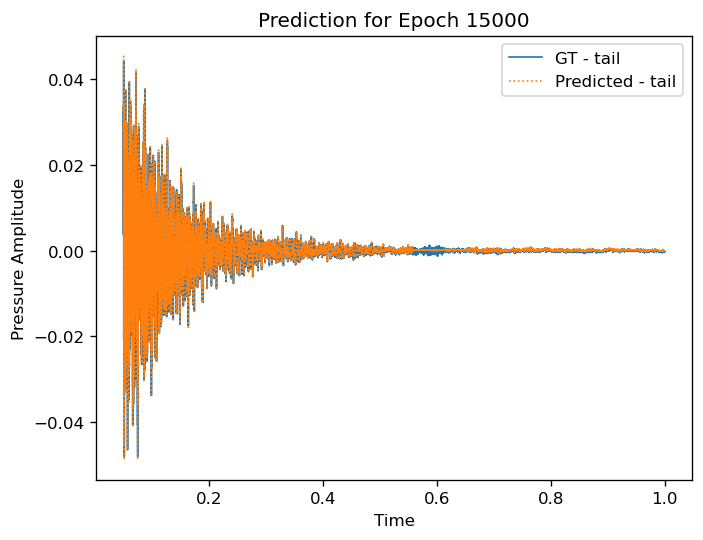

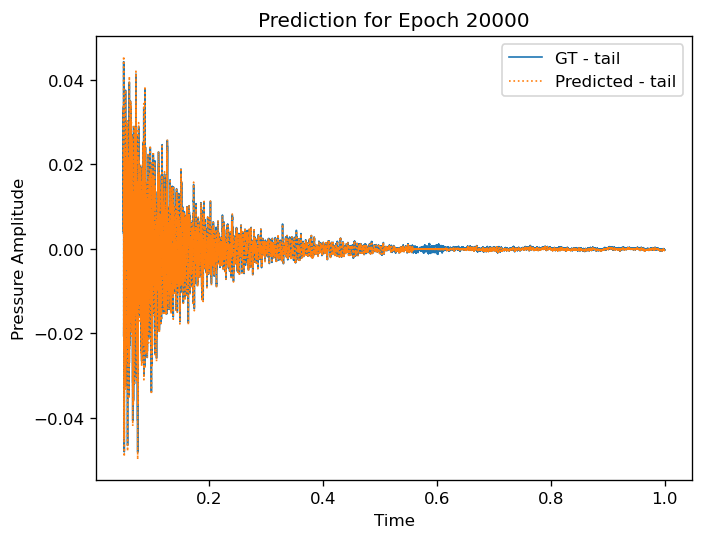

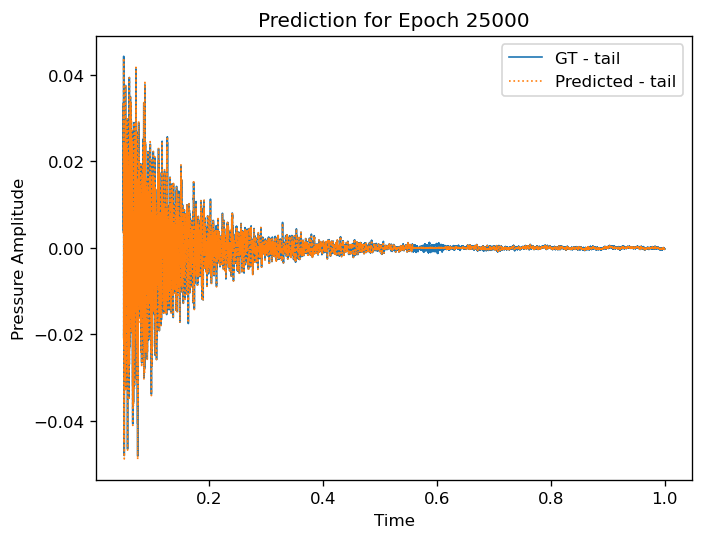

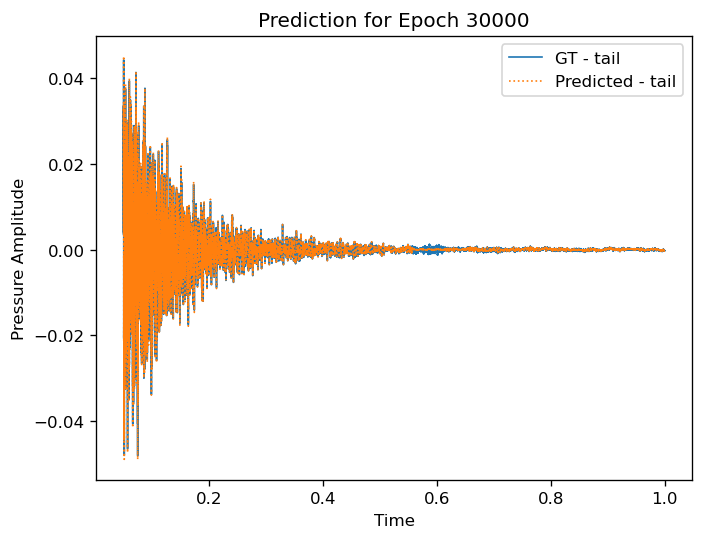

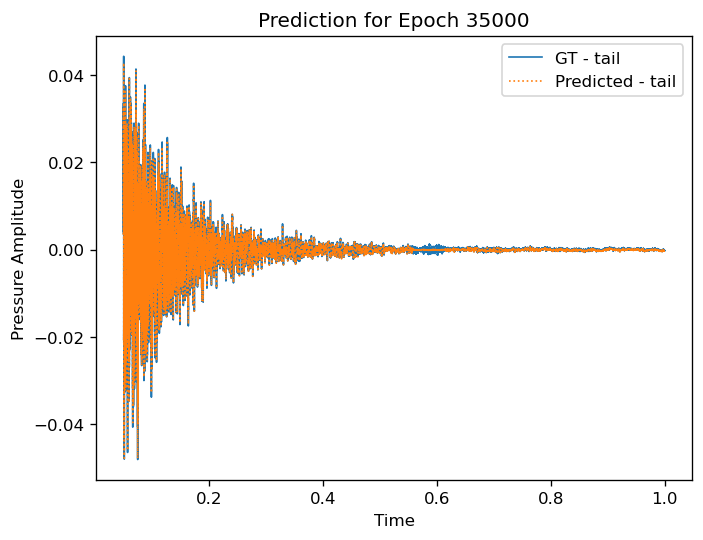

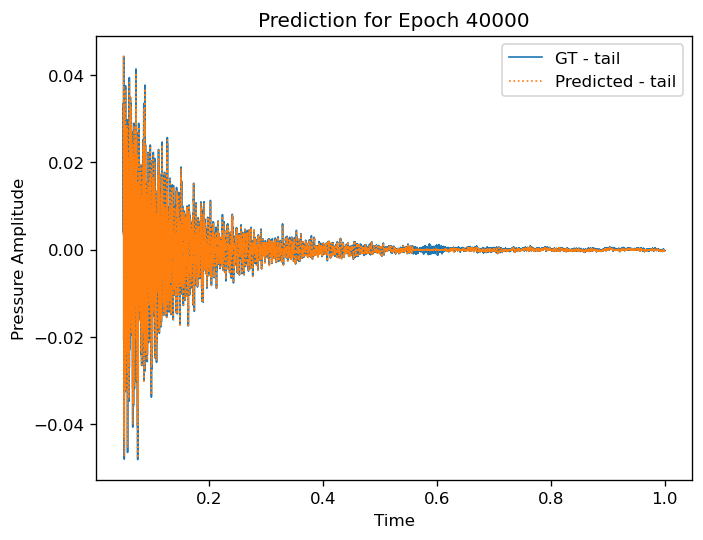

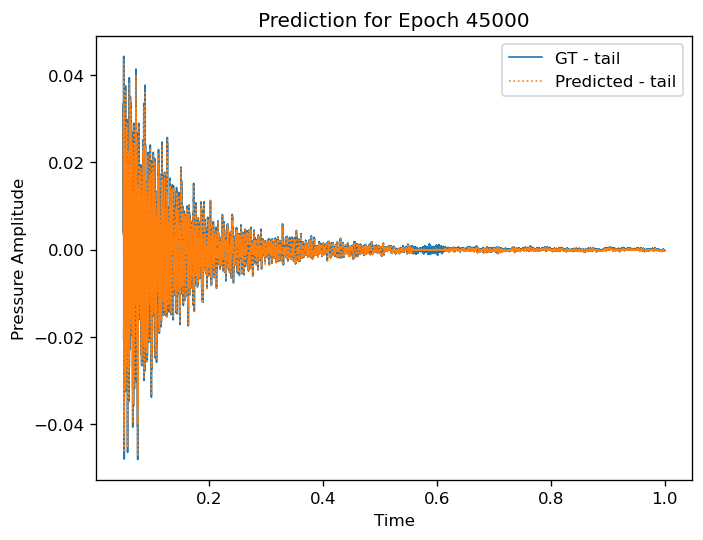

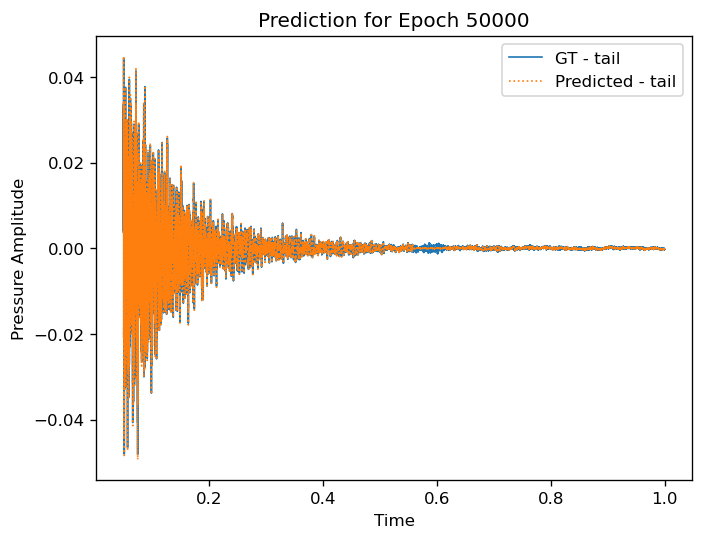

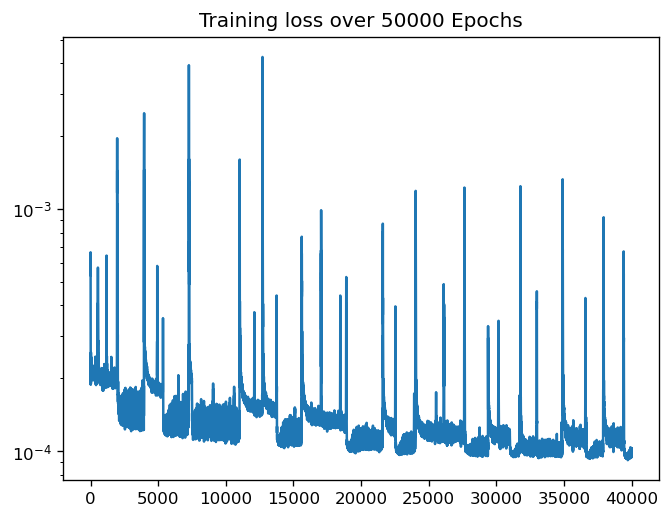

In [76]:
###### Training #######
model_name = "CNN1d_UNET_L1"
if not skip_training:
    EPOCHS = 50000
    optimizer = torch.optim.Adam(cnn_model.parameters(), lr=0.001)
    criterion = nn.L1Loss()
    loss_over_time = []

    for epoch in range(10000, EPOCHS):
        cnn_model.train()
        total_loss = 0
        for x, y in trainloader:
            x = x.to(device).float()
            y = y.to(device).float()
            out = cnn_model(x)
            
            # Zero gradient of optimizer:
            optimizer.zero_grad()
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        loss_over_time.append(total_loss/len(trainloader))
        
        if epoch==0 or epoch==9 or epoch==49 or epoch==99 or epoch==199 or epoch%500 == 499:
            print(f"Epoch {epoch+1}. Loss: {total_loss/len(trainloader)}")
        if epoch == 9 or epoch%5000==4999:
            x, y, y_pred = plot_model_output(cnn_model, trainset, epoch, 
                              criterion=criterion, 
                              save_file=True, 
                              filename=output_dir+model_name + "_epoch" + str(epoch+1).zfill(5) + "_pred.png")

    # save and plot training loss
    np.save(output_dir+model_name+"_train_loss", loss_over_time)
    
    fig, ax = plt.subplots(1)
    ax.plot(loss_over_time[5:])
    ax.set_yscale('log')
    ax.set_title(f'Training loss over {EPOCHS} Epochs')
    plt.savefig(output_dir+model_name + "_train_loss.png", bbox_inches="tight")
    plt.show()

In [77]:
if not skip_training:
    tools.save_model(cnn_model, output_dir+model_name+'.pth', confirm=True)

Do you want to save the model (type yes to confirm)?  yes


Model saved to ./output/CNN1d_UNET_L1.pth.


### Evaluation

Plot model prediction, play GT and predicted audio

Loss: 7.619034295203164e-05


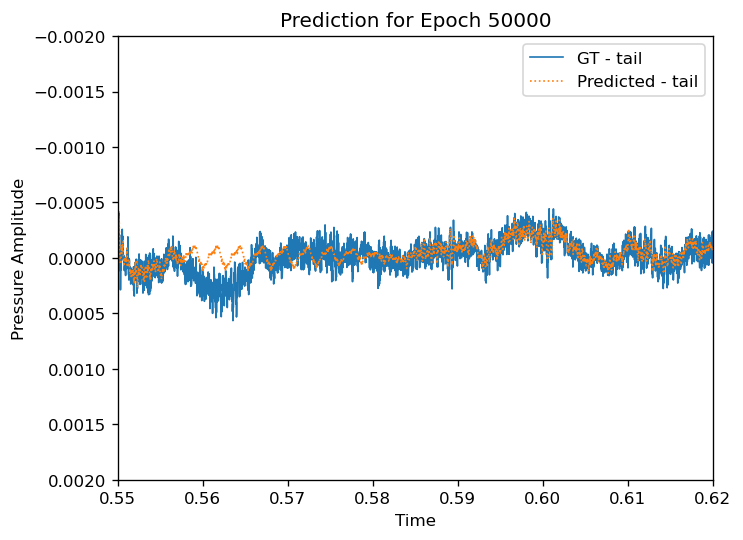

In [91]:
x, y, y_pred = plot_model_output(cnn_model, trainset, epoch, idx=1, criterion=criterion, xlim=[0.55,0.62], ylim=[0.002,-0.002])

Loss: 0.00011135522072436288


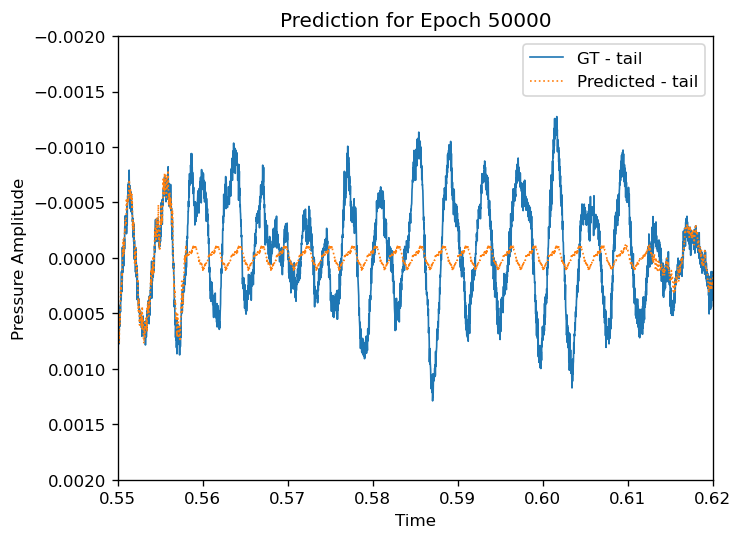

In [92]:
x, y, y_pred = plot_model_output(cnn_model, trainset, epoch, idx=0, criterion=criterion, xlim=[0.55,0.62], ylim=[0.002,-0.002])

Loss: 0.00011135522072436288


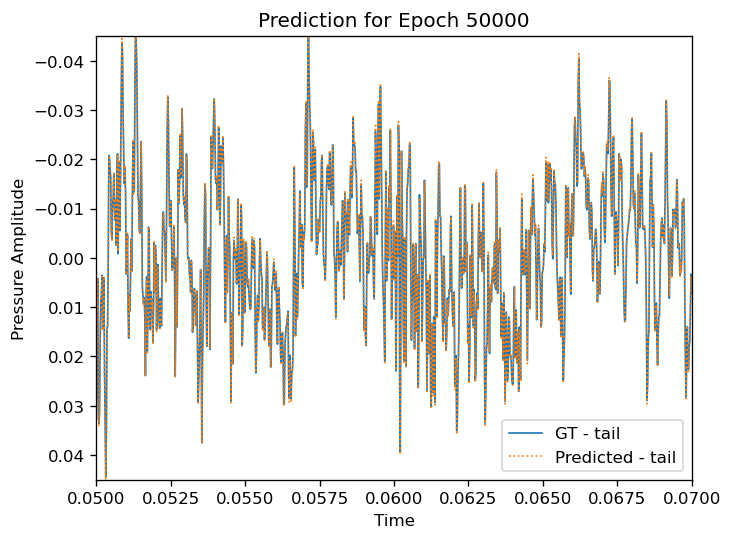

In [96]:
x, y, y_pred = plot_model_output(cnn_model, trainset, epoch, criterion=criterion, xlim=[0.05,0.07], ylim=[0.045,-0.045])

In [97]:
# Play GT IR
Audio(torch.cat((x,y)), rate=fs)

In [98]:
# Play predicted IR
Audio(torch.cat((x,y_pred)), rate=fs)

In [82]:
model_outputs = np.empty((len(trainset),2,len(sample_tail[0])))

for i in range(len(trainset)):
    _, y, y_pred = plot_model_output(cnn_model, 
                                     trainset, 
                                     epoch, 
                                     plot=False,
                                     idx=i)
    model_outputs[i,0,:] = y
    model_outputs[i,1,:] = y_pred
print(model_outputs)

[[[ 0.0324882   0.01361145  0.00418298 ... -0.00023703 -0.00021118
   -0.00023566]
  [ 0.03269409  0.01373429  0.00410376 ... -0.00025975 -0.00025516
   -0.00023755]]

 [[ 0.00566401  0.00251826 -0.0022837  ...  0.00011329  0.00013199
    0.00019578]
  [ 0.00561224  0.00220799 -0.00253001 ...  0.00011505  0.00010564
    0.00013998]]]


In [83]:
np.save("./output/"+model_name+"_gt_prediction1", model_outputs)

In [65]:
"./output/"+model_name+"_gt_prediction"

'./output/CNN1d_L1_gt_prediction'

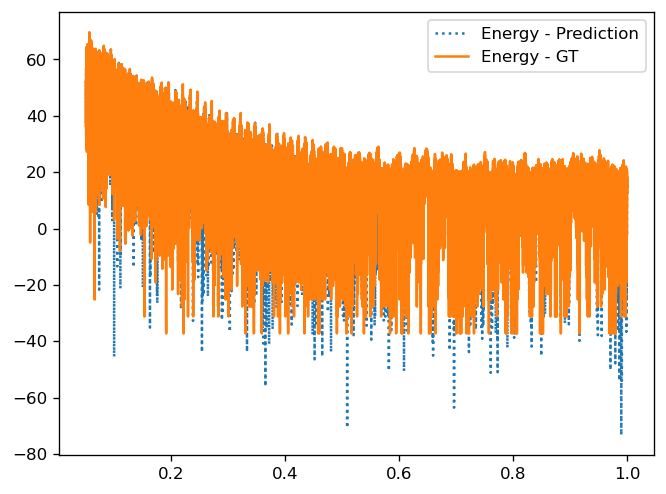

In [84]:
# Energy decay graph
with torch.no_grad():
#     cnn_model.eval()
#     x, y = trainset[0]
#     x = x[None,:,:].to(device).float()
#     y = y[None,:,:].cpu().float()
#     y_pred = cnn_model(x)
    
    pa_ref = 2e-5
    gt_energy = 10*torch.log10((torch.flatten(y)/pa_ref)**2)
    pred_energy = 10*torch.log10((torch.flatten(y_pred.cpu())/pa_ref)**2)
    fig, ax = plt.subplots(1)    
    ax.plot(time2, pred_energy, ':')
    ax.plot(time2, gt_energy)
    ax.legend(['Energy - Prediction', 'Energy - GT'])
    plt.show()

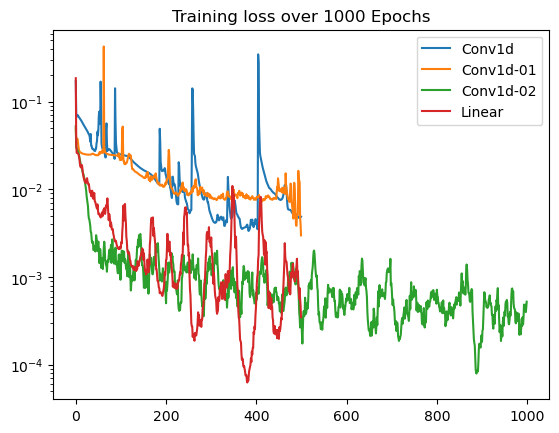

In [117]:
# Training loss across models
fig, ax = plt.subplots(1)  
ax.plot(loss_over_time)
ax.plot(loss_over_time01)
ax.plot(loss_over_time02)
ax.plot(loss_over_time_mlp)
ax.legend(['Conv1d','Conv1d-01', 'Conv1d-02','Linear'])
ax.set_yscale('log')
ax.set_title(f'Training loss over {EPOCHS} Epochs')
plt.savefig("cnn_cnn01_cnn02_mlp_training_loss.png", bbox_inches="tight")
plt.show()